In [1]:
# Import libraries and data
import sys
import numpy as np

sys.path.append('../../')

from src.data_processing.column_import import s_x ,s_y ,v_x ,v_y ,a_x ,a_y 
from src.scripts.linear_regressor import perform_linear_regression

Column dir
../../data/processed/x_y_recording_00_range_384.csv


## Acceleration Model (7 params)


Equation for the model 
\begin{align}
a(k-1) &=  - c_0 v(k-1) - c_1 a(k) + c_2 \bigl( v(k+1) - v(k) \bigr)                            \\
a(k-1) &= - c_3 s(k-1) - c_4v(k-1) - c_5 a(k)  + c_6 \bigl( s(k+1) - s(k) - dt \  v(k) \bigr)   \\
\end{align}

Here we solve the following system:
\begin{align}
    \begin{bmatrix}
        a(k-1) \\ 
        a(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        v(k-1)   & - a(k) &  v(k+1) - v(k) & 0 & 0 & 0 & 0          \\
        0 & 0 & 0 & - s(k-1) & - v(k-1) & -  a(k)  &+ \bigl( s(k+1) - s(k) - dt \  v(k) \bigr)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_0 \\
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
        \overline c_5 \\
        \overline c_6 \\
   \end{bmatrix}
\end{align}

We add the x and y components (imagine the matrix also contains the indices)
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_x(k-1) \\ 
        a_y(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        v(k-1)   & - a(k) &  v(k+1) - v(k) & 0 & 0 & 0 & 0          \\
        0 & 0 & 0 & - s(k-1) & - v(k-1) & -  a(k)  &+ \bigl( s(k+1) - s(k) - dt \  v(k) \bigr)   \\
        v(k-1)   & - a(k) &  v(k+1) - v(k) & 0 & 0 & 0 & 0          \\
        0 & 0 & 0 & - s(k-1) & - v(k-1) & -  a(k)  &+ \bigl( s(k+1) - s(k) - dt \  v(k) \bigr)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_0 \\
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
        \overline c_5 \\
        \overline c_6 \\
   \end{bmatrix}
\end{align}


We split the model into two models for easier implementation
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        v(k-1)   & - a(k) &  v(k+1) - v(k) \\
        v(k-1)   & - a(k) &  v(k+1) - v(k) \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_0 \\
        \overline c_1 \\
        \overline c_2 \\
   \end{bmatrix}
\end{align}


\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        - s(k-1) & - v(k-1) & -  a(k)  &s(k+1) - s(k) - dt \  v(k) \\
        - s(k-1) & - v(k-1) & -  a(k)  &s(k+1) - s(k) - dt \  v(k) \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_3 \\
        \overline c_4 \\
        \overline c_5 \\
        \overline c_6 \\
   \end{bmatrix}
\end{align}




Our model is in the form of:
\begin{equation}
t = Ax
\end{equation}

We can solve this using least squares
\begin{equation}
||t-Ax||^2
\end{equation}



## Matrix creation

|  k-1 |    k | k+1 |
| 0:-2 | 1:-1 |  2: |


In [2]:
# Target vector y
y = np.concatenate([a_x[1:-1], a_y[1:-1]])    # a(k)
y.shape


(410546,)

In [3]:
# Input features X_a of the first model
A = -v_x[0:-2]                 
B = -v_y[0:-2]                 
C =  a_x[1:-1] 
D =  a_y[1:-1] 
E =  v_x[2:] - v_x[1:-1]         
F =  v_y[2:] - v_y[1:-1]         

X_a = np.vstack((
    np.column_stack((A, C, E)), 
    np.column_stack((B, D, F))
    ))

X_a.shape

(410546, 3)

In [4]:
# Input features X_b of the second model
dt = 0.04

A = -s_x[0:-2]                                 
B = -s_y[0:-2]                                 
C = -v_x[0:-2] 
D = -v_y[0:-2] 
E = -a_x[1:-1] 
F = -a_y[1:-1] 
G =  s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        
H =  s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        

X_b = np.vstack((
    np.column_stack((A, C, E, G)), 
    np.column_stack((B, D, F, H))
    ))
X_b.shape


(410546, 4)

## Perform Regression

Mean Squared Error (MSE): 4.1552e-30
Mean Absolute Error (MAE): 2.0379e-15
R-squared (R²) Score: 1.0000e+00


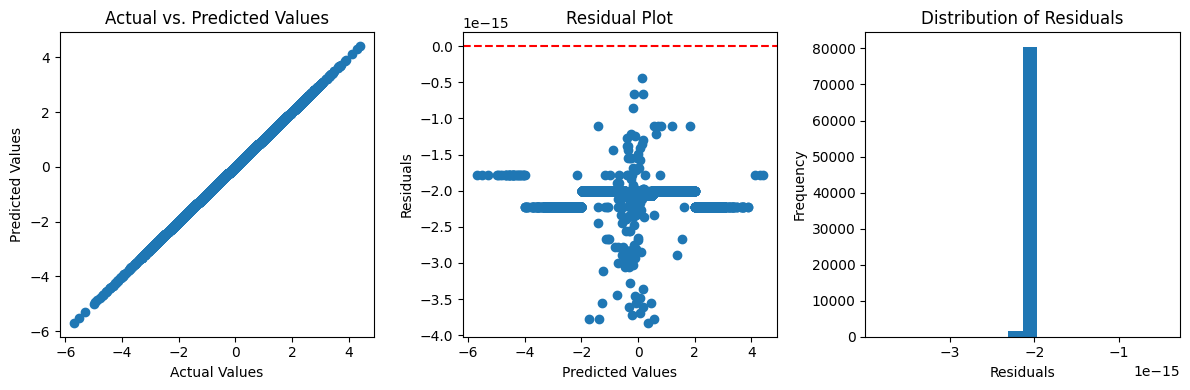

In [5]:
# First model
perform_linear_regression(X_a, y)


Mean Squared Error (MSE): 4.6333e-30
Mean Absolute Error (MAE): 2.0520e-15
R-squared (R²) Score: 1.0000e+00


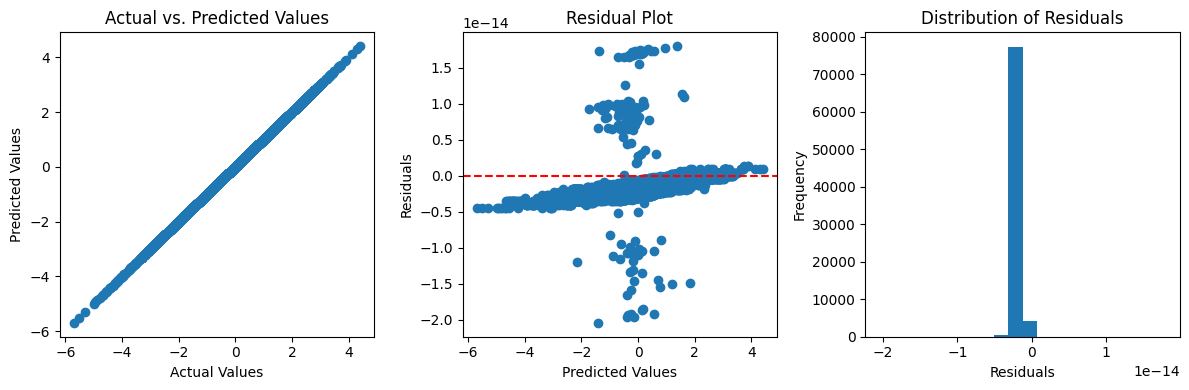

In [6]:
# Second model
perform_linear_regression(X_b, y)
